# 1. The SIR Model


## 1.1. Background

**Compartmental models** are a general modelling technique often applied to the mathematical modelling of infectious diseases. The **SIR model** is one of the simplest compartmental models and serves as a base for more specialized models.

\
 
The SIR model classifies individuals in a population into one of four states:


- **$s$** Susceptible individuals who can contract the disease from an infectious individual.
- **$e$**: Exposed individuals have come in contact with an infectious individual but are not yet infectious themselves.
- **$i$**: Infections individuals have been infected and are capable of infecting susceptible individuals.
- **$r$**: Removed individuals have either recovered and are resistant to the disease or have died. 

By default, all individuals begin in the *susceptible* ($s$) state and follow the path $s \rightarrow e \rightarrow i \rightarrow r$.

\

In order to model how the number of individuals in each of these states changes over time, we can use given time derivatives for each of the values:

\begin{align*}
    s'(t) &= - \beta (t) \cdot s(t) \cdot i(t) \\
    e'(t) &= \beta (t) \cdot s(t) \cdot i(t) - \sigma \cdot e(t) \\
    i'(t) &= \sigma \cdot e(t) - \gamma \cdot i(t)
\end{align*}

Where:

- $\beta (t)$ is the *transmission rate*, or the rate at which individuals interact in a way that would allow the disease to spread, and

\begin{align*}
    \beta (t) := R(t) \cdot \gamma 
\end{align*}

- $R(t)$ is the *effective transmission rate*, or the average number of secondary infections produced by a typical case of an infection.

- $\sigma$ is the *infection rate*, or the rate at which those exposed become infected. This value is assumed to be biologically constant.
- $\gamma$ is the *recovery rate*, or the rate at which those infected either recover with immunity or die. This value is assumed to be biologically constant.

\

Note that the removed portion of the population $r$ need not be defined, as the fact that the entire population fits into one of the four states implies:

\begin{align*}
    r(t) &= 1 - s(t) - e(t) - i(t) \\
    r'(t) &= -s'(t) - e'(t) - i'(t)
\end{align*}

\

### Additional parameters

We will track the total number of infections:

\begin{align*}
    i_{total} = i + r
\end{align*}

We will also vectorize the three differential equations:

\begin{align*}
    \frac{dx}{dt} = F(x,t) \\
    x := (s, e, i)
\end{align*}



---
# 2. Python Implementation

## 2.1. Importing Libraries

In [83]:
import matplotlib.pyplot as plt
# %inline matplotlib # sets the backend of matplotlib to the 'inline' backend
plt.rcParams["figure.figsize"] = (11,5) # set default figure size

import numpy as np # linspaces
from numpy import exp # exponential function

from scipy.integrate import odeint # solving differential equations

## 2.2. Initial Parameters

Default parameters correspond to the US in June 2020.

NOTE: incubation period and illness duration given in days.

In [84]:
#@title Inputs

population = 3.3e8 #@param {type:"raw"}
if type(population) != float and type(population) != int:
    print("\"population\" must be of type float or integer. Acceptable inputs take the form \"3.3e8\" or \"330_000_000\"")



# Both values below given in days
incubation_period = 5.2 #@param {type:"slider", min:1, max:10, step:0.1}
illness_duration = 18 #@param {type:"slider", min:1, max:30, step:1}

num_initially_ill = 33 #@param {type:"raw"}
if type(num_initially_ill) != int:
    print("\"num_initially_ill\" must be of type integer. Acceptable inputs take the form \"33\"")

months = 18 #@param{type:"slider", min: 1, max: 36, step:1}

In [85]:
# Working initial parameters

N = population
sigma = 1 / incubation_period
gamma = 1 / illness_duration

# initial values of s, e, and i in **proportions**
i_0 = num_initially_ill / N
e_0 = 4 * i_0
s_0 = 1 - i_0 - e_0
# vectorize the above
x_0 = s_0, e_0, i_0

## 2.3. Solving Differential Equations

We define a function corresponding to the second to last equation for $F(x,t)$.

Note that `R_0` is initially constant. In real life, this value would change as anti-COVID measures such as lockdowns are implemented. We will explore $R(t)& in a later section.

In [86]:
def F(x, t, R_0 = 1.6):
    '''
    Find time derivative of vectorized state x
        x is vectorized state (s,e,i)
        t is the time
        R_0 is the effective rate of transmission, which is a constant sourced by the WHO by default
    '''
    s, e, i = x

    # Susceptible individuals are exposed
    beta = R_0(t) * gamma if callable(R_0) else R_0 * gamma
    ne = beta * s * i
    
    # Differential equations
    ds = -ne
    de = -sigma * e + ne
    di = sigma * e - gamma * i

    return ds, de, di 

## 2.4. Numerical Integration (First order Euler's method)

In [87]:
def step(R_0, t_vec, x_initial = x_0):
    '''
    Solve for i(t) and i_total via numerical integration
    '''
    G = lambda x, t: F(x, t, R_0)
    s_step, e_step, i_step = odeint(G, x_initial, t_vec).transpose()
    c_step = 1 - s_step - e_step
    return i_step, c_step

---
# 3. Test Cases

In [88]:
t_length = months * 30
grid = 1000
t_vec = np.linspace(0, t_length, grid)

## 3.0. Function for Plotting Time Paths

In [89]:
def plot_path(paths, lables, times=t_vec):
    fig, ax = plt.subplots()

    for path, label in zip(paths, labels):
        ax.plot(times, path, label=label)
    
    ax.legend(loc="upper left")
    plt.show()

## 3.1. Case 1: Constant Rate of Transmission R_0

Note: In real life, R_0 would change as anti-COVID measures such as lockdowns are implemented. We will explore $R(t)& in a later section.

First we numerically integrate over time:

In [91]:
R_0_vals = np.linspace(1.6, 3.0, 6)
labels = [f'$R0 = {r:.2f}$' for r in R_0_vals]
i_paths, c_paths = [], []

for r in R_0_vals:
    i_step, c_step = step(r, t_vec)
    i_paths.append(i_step)
    c_paths.append(c_step)

Then we can plot current cases as a fraction of the population:

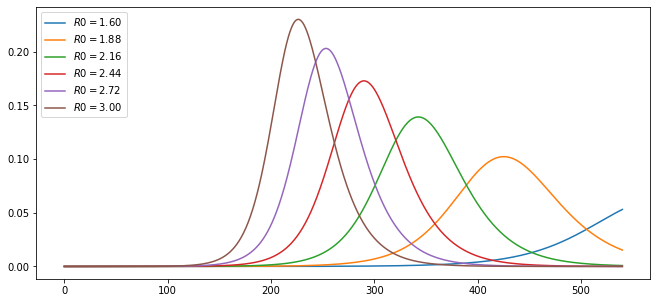

In [92]:
plot_path(i_paths, labels)

As well as cululative cases as a fraction of the popuation:

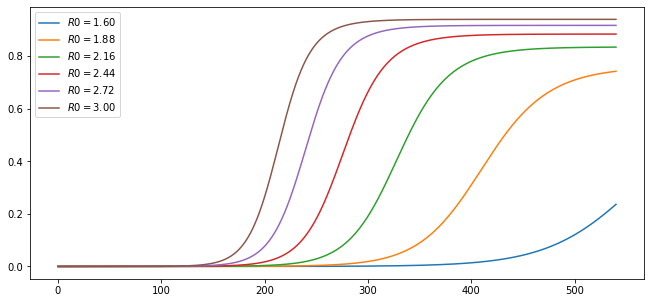

In [94]:
plot_path(c_paths, labels)